In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
from cpnDISORTlib import *
from cpnRetrievalslib import Bispec_LUT
import cpnCommonlib as cpn
cpn.setup_figures(plt)

## Previous LUTs

In [154]:
#Old LUTs
SZA=120
LUT=Bispec_LUT('/umbc/xfs1/zzbatmos/users/charaj1/LES_MSCART_retrievals/LUTs/',\
                   'MODIS_LUT_extended_SZA%03d_RAA000.nc'%(180-int(SZA)))
LUT.readLUT()

#High-resolution MSCART LUTs
LUTMC=Bispec_LUT('/umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LUTs/using_MSCART/',\
                   'LESLUT_highres_SZA120_nadir.hdf5')
LUTMC.readLUT(pro_type="MSCART_highres")

/umbc/xfs1/zzbatmos/users/charaj1/taki/softs/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Text(0, 0.5, 'COT')

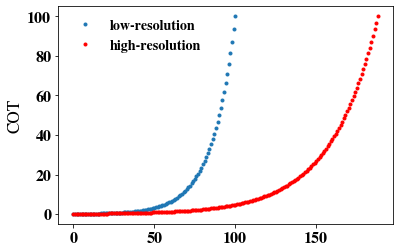

In [12]:
plt.plot(LUT.tau,'.',label='low-resolution')
new_tau=np.concatenate([np.array(LUT.tau),np.array((LUT.tau[1:]+LUT.tau[0:-1])/2)])
new_tau.sort()
new_tau=np.unique(new_tau.round(2))
plt.plot(new_tau,'r.',label='high-resolution')
plt.legend()
plt.ylabel('COT')

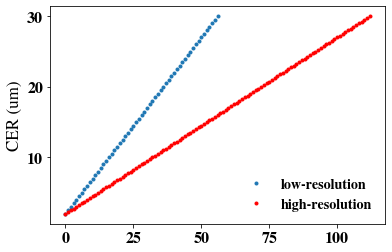

In [13]:
plt.plot(LUT.re,'.',label='low-resolution')
new_re=np.concatenate([np.array(LUT.re),np.array((LUT.re[1:]+LUT.re[0:-1])/2)])
new_re.sort()
new_re=np.unique(new_re.round(2))
plt.plot(new_re,'r.',label='high-resolution')
plt.ylabel('CER (um)')
plt.legend()

In [62]:
LUT.band[0],LUT.tau[57],LUT.ve[4],LUT.re[20]

(0.86, 5.12861, 0.05, 12.0)

Text(0.5, 0, 'VZA')

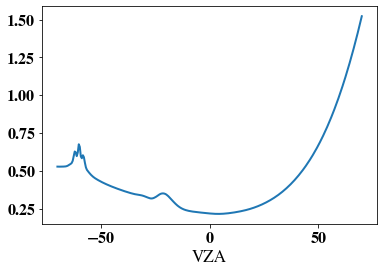

In [141]:
plt.plot(np.hstack((np.ones(150),np.ones(150)*-1))*np.rad2deg(np.arccos(LUT.mu)),LUT.I[0,57,4,21,:])
plt.xlabel('VZA')

#### Testing scattering angle computation

In [73]:
"phi=%f,mu0=%f"%(LUT.phi,LUT.mu0)

'phi=0.000000,mu0=0.500000'

In [95]:
vza=np.rad2deg(np.arccos(LUT.mu))
sza=np.rad2deg(np.arccos(LUT.mu0))
RAA = np.zeros(300,dtype=float)
RAA[150:]=180

In [96]:
sa=scat_ang(180-sza,vza,RAA)

Text(0.5, 0, 'Scattering Angle')

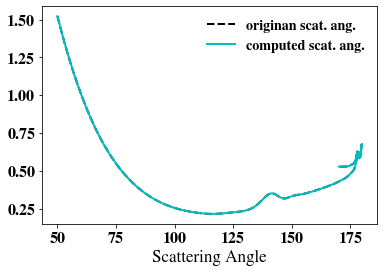

In [140]:
plt.plot(LUT.scat,LUT.I[0,57,4,21,:],'k--',label='original scat. ang.')
plt.plot(sa,LUT.I[0,57,4,21,:],'c',label='computed scat. ang.')
plt.legend()
plt.xlabel('Scattering Angle')

# DISOROT runs

[1] Kokhanovsky cloud example. (Use Kokhanovsky_cld.py to run DISORT for Kokhanovsky cloud case)

[2] Setting-up inputFiles to DISORT to generate LUT (Use run.slurm LUT_runs.py)

[3] Reading DISORT data and creating LUTs

- This is the newly-created LUT: '/umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LUTs/using_DISORT/DISORTLESLUT_highres_SZA120_nadir_LowRe5p1.hdf5'

#### [1] Kokhanovsky cloud example
##### How to read DISORT ouput

In [368]:
I,SZA,SAA,VZA,VAA,ScatA=read_disort()

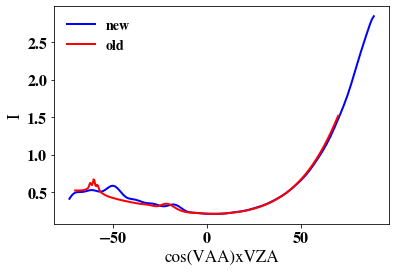

In [369]:
plt.plot(np.cos(np.rad2deg(VAA))*VZA,np.pi*I/np.cos(np.deg2rad(SZA)),'b',label='new')
plt.plot(np.hstack((np.ones(150),np.ones(150)*-1))*np.rad2deg(np.arccos(LUT.mu)),LUT.I[0,57,4,21,:],'r',label='old')
plt.xlabel('cos(VAA)xVZA')
plt.ylabel('I')
plt.legend()

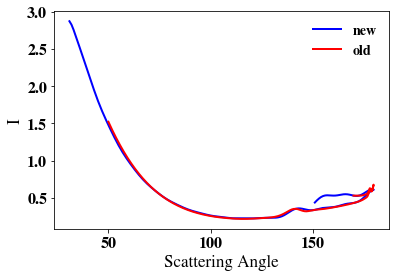

In [224]:
plt.plot(ScatA,np.pi*I/np.cos(np.deg2rad(SZA)),'b',label='new')
plt.plot(LUT.scat,LUT.I[0,57,4,21,:],'r',label='old')
plt.xlabel('Scattering Angle')
plt.ylabel('I')
plt.legend()

#### [2] Setting-up inputFiles to DISORT to generate LUT

In [226]:
from cpnMielib import bulk_Mie,PSDs,MieSet

In [227]:
mie = MieSet('DYCOM2_dharma_008036_mie_470_860_2p13',path='/umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LES_simulations/')
mie.readMie()

In [458]:
psd = PSDs("high_res_LUT",D=np.asarray(mie.d,dtype=float))
psd.set_mod_gamma_norm(2.0,0.05)
bM=bulk_Mie("highres_bulkMie_for_LES",psd=psd,Mie=mie)
t0=time.time()
bM.cal_bulk_Pmat()
t1=time.time()
print(t1-t0)

Averaging for bulk Pmat........
5.1048243045806885


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2aaaea9bd198>)

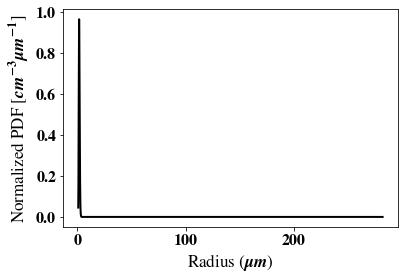

In [459]:
psd.plot_nN()

In [460]:
re = bM.psd.re #um
ve = bM.psd.ve
Ang = bM.Mie.ang
P11 = bM.bulk_P11[:,1]
Mu = np.cos(np.radians(Ang))

# check if the phase function is normalized
C =-0.5*np.trapz(P11,Mu) # negative sign is because the integration should be from -1 to 1, but Mu is from 1 to -1
print('normalization',C)
if C>0.99999:
    print("Phase function is normalized.")
else:
    print("Warning!!: Phase function is not normalized!!")

print('Computing Legendre polynomials....')
N=np.arange(0,900)
g = []
for n in N:
    f =  legendre(n)
    L = f(Mu)
    g.append(-0.5*np.trapz(P11*L,Mu))
g = np.array(g)

normalization 1.0000001167083044
Phase function is normalized.
Computing Legendre polynomials....


/umbc/xfs1/zzbatmos/users/charaj1/taki/softs/anaconda3/lib/python3.7/site-packages/scipy/special/orthogonal.py:141: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/umbc/xfs1/zzbatmos/users/charaj1/taki/softs/anaconda3/lib/python3.7/site-packages/scipy/special/orthogonal.py:1977: RuntimeWarning: overflow encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/umbc/xfs1/zzbatmos/users/charaj1/taki/softs/anaconda3/lib/python3.7/site-packages/scipy/special/orthogonal.py:1977: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n


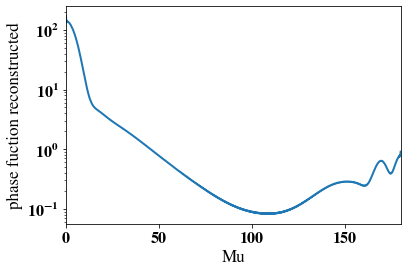

In [461]:
#reconstruct phase fuction with its legendre polynomial expantions
p11_test = 0
for n in N:
    f =  legendre(n)
    L = f(Mu)
    p11_test += (2*n+1)*g[n]*L


fig,ax = plt.subplots()
ax.plot(Ang,p11_test)
ax.set_yscale('log')
ax.set_xlim([0,180])
ax.set_xlabel('Mu')
ax.set_ylabel(r'phase fuction reconstructed')

plt.show()

##### Checking SSA spectral dependance

In [76]:
new_re=np.concatenate([np.array(LUT.re),np.array((LUT.re[1:]+LUT.re[0:-1])/2)])
new_re.sort()
new_re=np.unique(new_re.round(2))
new_tau=np.concatenate([np.array(LUT.tau),np.array((LUT.tau[1:]+LUT.tau[0:-1])/2)])
new_tau.sort()
new_tau=np.unique(new_tau.round(2))
re_list = new_re#np.unique(LUT.re.round(2))
cot_list = new_tau #np.unique(LUT.tau.round(2))

In [ ]:
from cpnMielib import MieSet,PSDs,bulk_Mie
mie = MieSet('DYCOM2_dharma_008036_mie_470_860_2p13',path='/umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LES_simulations/')
mie.readMie()
psd = PSDs("high_res_LUT",D=np.asarray(mie.d,dtype=float))
SCAb1=np.zeros_like(re_list,dtype=float)
SCAb2=np.zeros_like(re_list,dtype=float)
g_asb1=np.zeros_like(re_list,dtype=float)
g_asb2=np.zeros_like(re_list,dtype=float)
for i in np.arange(re_list.size):
    psd.set_mod_gamma_norm(re_list[i],0.05)
    bM=bulk_Mie("highres_bulkMie_for_LES",psd=psd,Mie=mie)
    bM.cal_bulk_albnQe()
    SCAb1[i] = bM.bulk_alb[1]
    SCAb2[i] = bM.bulk_alb[2]
    bM.cal_bulk_Pmat()
    Mu = np.cos(np.radians(bM.Mie.ang))
    g_asb1[i]=-0.5*np.trapz(Mu*bM.bulk_P11[:,1],Mu)
    g_asb2[i]=-0.5*np.trapz(Mu*bM.bulk_P11[:,2],Mu)
    

Text(0, 0.5, 'SSA')

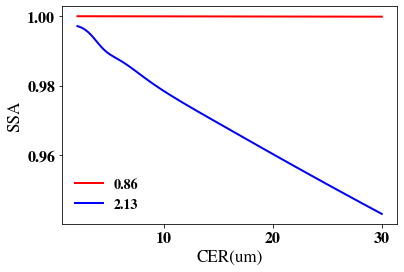

In [86]:
plt.plot(re_list,SCAb1,'r',label='0.86')
plt.plot(re_list,SCAb2,'b',label='2.13')
plt.legend()
plt.xlabel('CER(um)')
plt.ylabel('SSA')

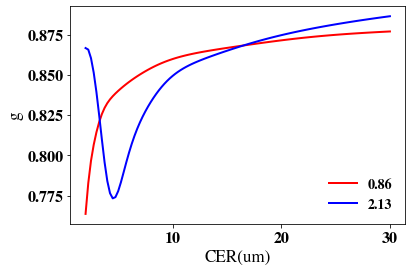

In [103]:
plt.plot(re_list,g_asb1,'r',label='0.86')
plt.plot(re_list,g_asb2,'b',label='2.13')
plt.xlabel('CER(um)')
plt.ylabel('g')
plt.legend()

In [112]:
bM.Mie.wvl

masked_array(data=[0.47, 0.86, 2.13],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

#### [3] Reading DISORT data and creating LUTs

In [519]:
bM.Mie.wvl

masked_array(data=[0.47, 0.86, 2.13],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [351]:
new_re=np.concatenate([np.array(LUT.re),np.array((LUT.re[1:]+LUT.re[0:-1])/2)])
new_re.sort()
new_re=np.unique(new_re.round(2))
new_re=new_re[(new_re>5.0)]#removing unsucessfull runs
# 5.0 and 4.75 mu CER tries failed. 5.1 works. Strangely the other smaller CERs worked. 
#new_re[new_re>5.0]=5.1
#new_re[new_re==4.75]=4.9#4.81
new_tau=np.concatenate([np.array(LUT.tau),np.array((LUT.tau[1:]+LUT.tau[0:-1])/2)])
new_tau.sort()
new_tau=np.unique(new_tau.round(2))

LUTnew=Bispec_LUT('/umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LUTs/using_DISORT/','DISORTLESLUT_highres_SZA120_nadir.hdf5')
LUTnew.band=np.array([0.860,2.13])
LUTnew.re = new_re
LUTnew.ve = np.array([ve])
LUTnew.tau = new_tau
LUTnew.mu0 = np.cos(np.deg2rad(60))
LUTnew.phi = 0.0
LUTnew.mu = np.array([1.0])
LUTnew.scat = np.array([119.99])
RI = np.zeros((2,new_tau.size,new_re.size),dtype=float)
ni = LUTnew.re.size
nj = LUTnew.tau.size
i,j = 0,0
largeVN,largeSW=0,0
f0p86 = open('b0p860_missing.dat','w')
f0p86.close()
f2p13 = open('b2p13_missing.dat','w')
f2p13.close()
start = time.time()
for re in LUTnew.re:
    j=0
    for COT in LUTnew.tau:
        I,SZA,SAA,VZA,VAA,ScatA=read_disort(filename="results/LUTsHigh0p860/LUT_ve0p05re"+("%0.2f"%(re)).replace(".","p")\
                                            +"COT"+("%0.2f"%(COT)).replace(".","p")+"SZA60p0000_INTENSITY.dat")
        I2,_,_,_,_,_=read_disort(filename="results/LUTsHigh2p13/LUT_ve0p05re"+("%0.2f"%(re)).replace(".","p")\
                                            +"COT"+("%0.2f"%(COT)).replace(".","p")+"SZA60p0000_INTENSITY.dat")
        RI[0,j,i] = np.pi*I[90]/np.cos(np.deg2rad(SZA[90]))
        RI[1,j,i] = np.pi*I2[90]/np.cos(np.deg2rad(SZA[90]))
        if np.isnan(I2[90]) or I2[90]>10: 
            largeSW+=1
            f2p13 = open('b2p13_missing.dat','a')
            f2p13.write("results/LUTsHigh2p13/LUT_ve0p05re"+("%0.2f"%(re)).replace(".","p")\
                                            +"COT"+("%0.2f"%(COT)).replace(".","p")+"SZA60p0000_INTENSITY.dat"+'\n')
            f2p13.close()
        if np.isnan(I[90]) or I[90]>10:
            largeVN+=1
            f0p86 = open('b0p860_missing.dat','a')
            f0p86.write("results/LUTsHigh0p860/LUT_ve0p05re"+("%0.2f"%(re)).replace(".","p")\
                                            +"COT"+("%0.2f"%(COT)).replace(".","p")+"SZA60p0000_INTENSITY.dat"+'\n')
            f0p86.close()            
        j+=1
        cpn.progress_bar(i,j,ni,nj,start)
    i+=1
LUTnew.I=np.zeros((2,new_tau.size,1,new_re.size,1))
LUTnew.I[:,:,0,:,0]=RI
print(largeVN,largeSW)

100.01% 0 minutes remaining ... 0 0


In [358]:
LUTnew.fname='DISORTLESLUT_highres_SZA120_nadir_LowRe5p1.hdf5'

In [359]:
LUTnew.save_LUT()

DISORTLESLUT_highres_SZA120_nadir_LowRe5p1.hdf5 SAVED!


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2aaae5cb52b0>)

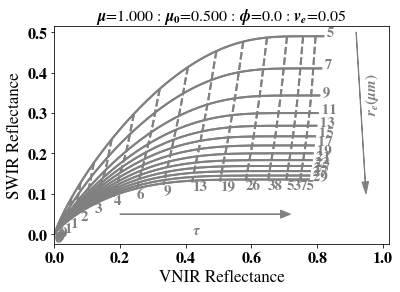

In [360]:
LUTnew.plotLUT(0,ve=0.05,pro_type='MSCART',re_lines=np.array([5.25,7,9,11,13,15,17,19,21,23,25,27,29]))

##### Testing the accuracy of the LUT computations

- CER~5.00 ish values are gone! This is because DISORT gives consecutively failed computation on those values that I did not explore yet.

Text(0.5, 1.0, '$\\mu$=1.000 : $\\mu_0$=0.500 : $\\phi$=0.0 : $v_e$=0.05')

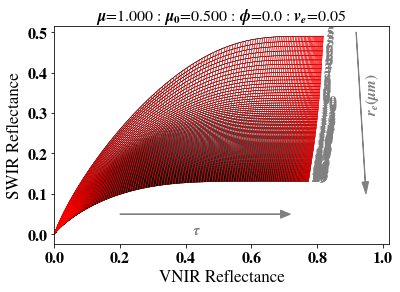

In [361]:
def plotLUT(VNIR_lut,SWIR_lut,reff_lut,tau_lut,re_lines=None,figAx=None,gcolor='grey'):
    '''
    To plot LUT. fig and ax instances will be returned to over plot data.
    re_lines:  Array of re values that are needed to be shown on the LUT plot.
                Make sure all the values are available in self.re
    '''
    if figAx is None:
        fig_LUT,axLUT=plt.subplots()
    else:
        fig_LUT,axLUT=figAx[0],figAx[1]
    if re_lines is None:
        for i in np.arange(0,reff_lut.size,10):
            x=np.squeeze(VNIR_lut[i,:]);y=np.squeeze(SWIR_lut[i,:])
            axLUT.plot(x,y,'k.')
            axLUT.text(x.max(),y.max(),' %d'%reff_lut[i],color=gcolor)
        re_min_ix=np.argmin(reff_lut)
    else:
        p=np.repeat(re_lines,reff_lut.size).reshape(re_lines.size,reff_lut.size)
        q=np.repeat(reff_lut,re_lines.size).reshape(reff_lut.size,re_lines.size)
        re_ln_ix=np.where((p-q.T)==0)[1]
        for i in re_ln_ix:
            x=np.squeeze(VNIR_lut[i,:]);y=np.squeeze(SWIR_lut[i,:])
            axLUT.plot(x,y,'k-',lw=0.5)
            axLUT.text(x.max(),y.max(),' %d'%reff_lut[i],color=gcolor)
        re_min_ix=np.squeeze(np.argwhere(reff_lut==re_lines.min()))
    for j in np.arange(0,tau_lut.size,1):
        x=np.squeeze(VNIR_lut[re_min_ix:,j]);y=np.squeeze(SWIR_lut[re_min_ix:,j])
        axLUT.plot(x,y,'r-',lw=0.5)
        #axLUT.text(x.min,y.min()-0.02,r'%d'%tau_lut[j],color=gcolor)
        axLUT.set_xlabel('VNIR Reflectance')
        axLUT.set_ylabel('SWIR Reflectance')
    axLUT.set_xlim(0,VNIR_lut.max()+0.2)
    axLUT.arrow(VNIR_lut.max()+.1,0.5,0.03,-0.4,linestyle='-',head_width=0.02,\
              length_includes_head=True,color=gcolor)
    axLUT.annotate(r' $r_e$($\mu m$)',xy=(VNIR_lut.max()+0.12,0.3),color=gcolor,rotation=90)
    axLUT.arrow(0.2,0.05,VNIR_lut.max()-0.3,0,linestyle='-',head_width=0.02,\
              length_includes_head=True,color=gcolor)
    axLUT.annotate(r' $\tau$',xy=(VNIR_lut.max()/2,0),color=gcolor)
    fig_LUT.show()
    return fig_LUT,axLUT
mu_ix=0;re_lines=LUTnew.re; figAx=None;gcolor='grey'
LUT_VNIR=LUTnew.I[0,:,np.where(LUTnew.ve==ve),:,mu_ix].T
LUT_SWIR=LUTnew.I[1,:,np.where(LUTnew.ve==ve),:,mu_ix].T
#LUT_VNIR[LUT_VNIR>10]=np.nan
#LUT_SWIR[LUT_SWIR>10]=np.nan
if re_lines is None:
    fig_LUT,axLUT=plotLUT(LUT_VNIR,LUT_SWIR,LUTnew.re[:],LUTnew.tau,figAx=figAx,gcolor=gcolor)
else:        
    fig_LUT,axLUT=plotLUT(LUT_VNIR,LUT_SWIR,LUTnew.re,LUTnew.tau,re_lines=re_lines,figAx=figAx,gcolor=gcolor)
axLUT.set_title(r'$\mu$=%0.3f : $\mu_0$=%0.3f : $\phi$=%0.1f : $v_e$=%0.2f'%(LUTnew.mu[mu_ix],LUTnew.mu0,LUTnew.phi,ve))

## Testing Legendre polynomial expansion of the phase function 

[1] An attempt to compile GETMOM as a Python library.
- To compile for python,
 - f2py -c GETMOM2PY.f90 ERRPACK.f -m GETMOM2PY
 - Did not work properly
 - pmom has to be a fixed-size array in the Fortran code. Made it 900. (line38       REAL      PMOM( 0:900 ) in GETMOM2PY) 
 
[2] Reconstruction of DISORT example Kokhanovsky case phase function

[3] Kokhanovsky cloud phase function

[4] Comparing re-constructed example case [2] with new Legendre expansion results
- Newly computed values are more acurate than DISORT example values

#### [1] An attempt to compile GETMOM as a Python library.

In [2]:
import numpy as np
import  GETMOM2PY as getm
pmom=np.zeros(901)
getm.getmom(7,0.0,900,pmom)

In [ ]:
pmom

#### [2] Reconstruction of DISORT example Kokhanovsky case phase function

In [88]:
from scipy.special import legendre
import time
lm=np.loadtxt('LegMomKkyCld.dat')
I,SZA,SAA,VZA,VAA,ScatA=read_disort()

Text(0.5, 0, 'Number of terms')

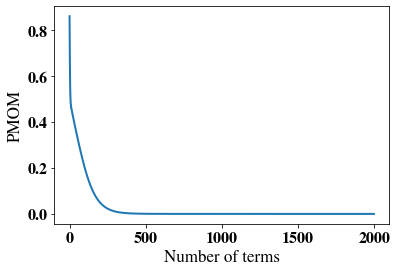

In [101]:
plt.plot(lm)
plt.ylabel('PMOM')
plt.xlabel('Number of terms')

In [89]:
t0 = time.time()
M = np.arange(0,900)
Mu =  np.cos(np.radians(ScatA))
p11_test = 0
for n in M:
    f =  legendre(n)
    L = f(Mu)
    p11_test += (2*n+1)*lm[n]*L
t1 = time.time()
print('%0.2f minutes elapsed!'%((t1-t0)/60))

0.31 minutes elapsed!


Text(0, 0.5, 'phase fuction reconstructed')

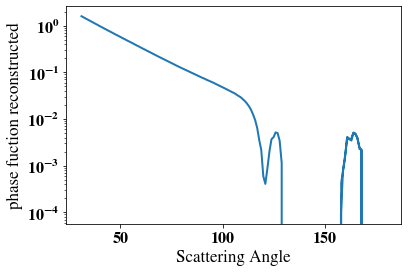

In [90]:
fig,ax = plt.subplots()
ax.plot(ScatA,p11_test)
ax.set_yscale('log')
#ax.set_xlim([0,180])
ax.set_xlabel('Scattering Angle')
ax.set_ylabel(r'phase fuction reconstructed')

#### [3] Kokhanovsky cloud phase function

Reference: /umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LUTs/using_DISORT/P11/Zhibo_P11/

normalization 0.9999955506742297


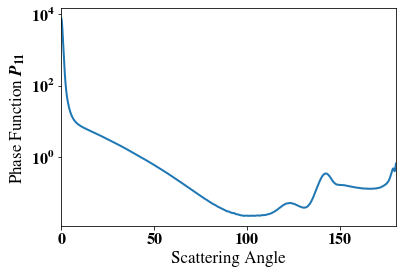

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.special import legendre

Data = np.loadtxt('P11/Zhibo_P11/Kokhanovsky_benchmark_cloud.PDA',skiprows=6)
Ang = Data[:,0]
P11 = Data[:,1]

fig,ax=plt.subplots()

ax.plot(Ang,P11)
ax.set_yscale('log')
ax.set_xlim([0,180])
ax.set_xlabel('Scattering Angle')
ax.set_ylabel(r'Phase Function $P_{11}$')


Mu = np.cos(np.radians(Ang))

# check if the phase function is normalized
C =-0.5*np.trapz(P11,Mu) # negative sign is because the integration should be from -1 to 1, but Mu is from 1 to -1
print('normalization',C)



Text(0, 0.5, 'PMOM')

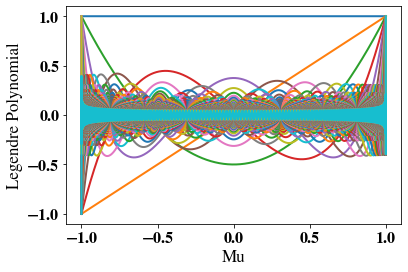

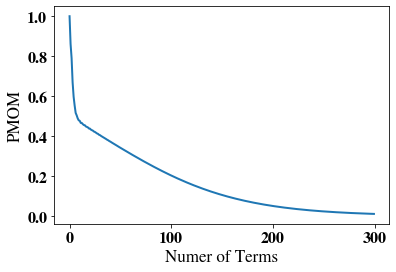

In [80]:
N=np.arange(0,300)
g = []
fig,ax= plt.subplots()
for n in N:
    f =  legendre(n)
    L = f(Mu)
    g.append(-0.5*np.trapz(P11*L,Mu))
    ax.plot(Mu,f(Mu))
ax.set_xlabel('Mu')
ax.set_ylabel(r'Legendre Polynomial')

fig,ax= plt.subplots()
ax.plot(g)
ax.set_xlabel('Numer of Terms')
ax.set_ylabel(r'PMOM')



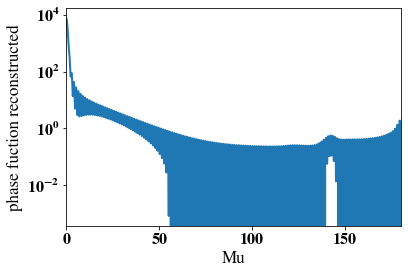

In [81]:
#reconstruct phase fuction with its legendre polynomial expantions
p11_test = 0
for n in N:
    f =  legendre(n)
    L = f(Mu)
    p11_test += (2*n+1)*g[n]*L


fig,ax = plt.subplots()
ax.plot(Ang,p11_test)
ax.set_yscale('log')
ax.set_xlim([0,180])
ax.set_xlabel('Mu')
ax.set_ylabel(r'phase fuction reconstructed')

plt.show()


#### [4] Comparing re-constructed example case in [2] with new Legendre expansion results in [3]

Text(0.5, 1.0, 'PMOM comparison')

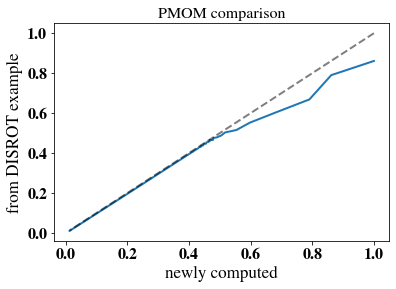

In [102]:
plt.plot(g,lm[:300])
plt.plot(g,g,'k--',alpha=0.5)
plt.xlabel('newly computed')
plt.ylabel('from DISROT example')
plt.title('PMOM comparison')
